# Decision Tree on Yearly Aggregates
<a id='top'></a>

<a href=#readdata>Read Data</a>  

<a href=#features>Feature Selection</a>

<a href=#dt>Decision Tree</a>

<a href=#inspectfeatures>Inspect Features</a>

<a href=#dummy>One Hot Encode</a>

<a href=#feature_importance>Feature Importance</a>

<a href=#balancedata>Balance Data</a>

<a href=#dt_rebalance>Decision Tree on Re-Balance Data</a>

<a href=#plot>Plot ROC Curve</a>

<a href=#bottom>Bottom</a>


In [1]:
# Ignore 'dask' warning
import pandas as pd
import gcsfs
from google.cloud import storage
from pandas import DataFrame
from IPython.display import HTML
from google.cloud.storage import Blob
import datalab.storage as gcs_datalab
from datetime import date
import numpy as np

from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, GridSearchCV
from sklearn.utils import resample
from sklearn import preprocessing
from scipy.stats import sem
import pickle

from matplotlib import pyplot
import seaborn as sns
from scipy import stats

<a id='readdata'></a>
# Read Yearly Aggregated Data 
<a href=#top>Top</a>

In [2]:
# Setting up constants. All required
project = 'graydon-moving-indicator'
bucket_name = 'graydon-data'

In [3]:
# Initializing bucket
fs = gcsfs.GCSFileSystem(project='graydon-moving-indicator')
gcs = storage.Client()
bucket = gcs.get_bucket(bucket_name)

In [4]:
# Setting up constants. All required
project = 'graydon-moving-indicator'
bucket_name = 'graydon-data'

# Initializing bucket
fs = gcsfs.GCSFileSystem(project='graydon-moving-indicator')
gcs = storage.Client()
bucket = gcs.get_bucket(bucket_name)


# Setting up dictionary of column types
dtype={ 'id_company'  :np.float64,
        'id_branch'    :np.int64, 
        'code_sbi_2'         : np.float64, 
        'code_sbi_1'          :object, 
        'has_relocated':bool,
        'has_relocated_next_year ' : bool,
        'qty_address_mutations_total' :np.float64,
        #'has_name_change'  :bool,
        'ratio_operating_result_consolidated_operating_result': np.float64,
        'ratio_revenue_consolidated_revenue': np.float64,
        'qty_green_flags'   :np.float64,
        'qty_orange_flags'   :np.float64,
        'qty_red_flags'   :np.float64,
        'A'   :np.float64,
        'AA'   :np.float64,
        'AAA'   :np.float64,
        'B'   :np.float64,
        'BB'   :np.float64,
        'BBB'   :np.float64,
        'C'   :np.float64,
        'CC'   :np.float64,
        'CCC'   :np.float64,
        'D'   :np.float64,
        'NR'   :np.float64,
        'company_age'   :np.float64,
        'years_since_last_amt_consolidated_operating_result'   :np.float64,
        'years_since_last_amt_consolidated_revenue'   :np.float64,
        'years_since_last_amt_operating_result'   :np.float64,
        'years_since_last_qty_employees'   :np.float64,
        'years_since_last_amt_revenue'   :np.float64,
        'delta_qty_employees'   :np.float64,
        'delta_qty_issued_credit_reports'   :np.float64,
        'delta_score_payment_assessment'   :np.float64,
        'delta_score_payment_assessment'   :np.float64,
        'code_legal_form_has_changed ' : bool,
        'is_discontinued_any ' : bool,
        'has_financial_calamity ' : bool,
        'mean_amt_consolidated_operating_result'   :np.float64,
        'mean_amt_consolidated_revenue'   :np.float64,
        'mean_amt_operating_result'   :np.float64,
        'mean_amt_revenue'   :np.float64,
        'mean_qty_employees'   :np.float64,
        'mean_qty_issued_credit_reports'   :np.float64,
        'mean_score_payment_assessment'   :np.float64,
        'mean_score_pd'   :np.float64,
        'qty_address_mutations_year'   :np.float64,
        'qty_started_names_year'   :np.float64,
        'qty_stopped_names_year'   :np.float64,
        'qty_board_changes_year'   :np.float64,
        'variance_qty_issued_credit_reports'   :np.float64,
        'variance_score_payment_assessment'   :np.float64,
        'variance_score_pd'   :np.float64
      }


# Setting up dictionary of column types
parse_dates= ['date_month', 'date_relocation_last', 'date_relocation_penultimate']

def read_one_year_from_bucket_merged_csv(year, dir_prefix = ''):
    """ Reads a whole year of data from the already merged files """
    full_year_df = pd.DataFrame()
    print('Starting with year: ', year)
    print(dir_prefix)
    blob_list = list(bucket.list_blobs(prefix=dir_prefix))    
    for blob in blob_list:  
        print("blob", blob.name)
        if year in blob.name:
            print('Processing file: ', blob.name)
            with fs.open('graydon-data/' + blob.name) as f:
                full_year_df = pd.read_csv(f, sep=',', index_col=0, dtype=dtype, parse_dates=parse_dates)   
        print('The number of rows so far is: ', full_year_df.shape[0])
    return full_year_df



In [5]:
data_df = read_one_year_from_bucket_merged_csv(
    dir_prefix= 'including_scores/merged_per_year/merged_cleaned'
                                                   , year = '2017')

Starting with year:  2017
including_scores/merged_per_year/merged_cleaned
blob including_scores/merged_per_year/merged_cleaned/
The number of rows so far is:  0
blob including_scores/merged_per_year/merged_cleaned/2008_merged.csv
The number of rows so far is:  0
blob including_scores/merged_per_year/merged_cleaned/2009_merged.csv
The number of rows so far is:  0
blob including_scores/merged_per_year/merged_cleaned/2010_merged.csv
The number of rows so far is:  0
blob including_scores/merged_per_year/merged_cleaned/2011_merged.csv
The number of rows so far is:  0
blob including_scores/merged_per_year/merged_cleaned/2012_merged.csv
The number of rows so far is:  0
blob including_scores/merged_per_year/merged_cleaned/2013_merged.csv
The number of rows so far is:  0
blob including_scores/merged_per_year/merged_cleaned/2014_merged.csv
The number of rows so far is:  0
blob including_scores/merged_per_year/merged_cleaned/2015_merged.csv
The number of rows so far is:  0
blob including_scores/m

ValueError: 'date_relocation_last' is not in list

In [5]:
data_df = read_one_year_from_bucket_merged_csv(
    dir_prefix= 'including_scores/merged_per_year/aggregated'
                                                   , year = '2017')

Starting with year:  2017
including_scores/merged_per_year/aggregated
blob including_scores/merged_per_year/aggregated/
The number of rows so far is:  0
blob including_scores/merged_per_year/aggregated/2017_merged_cleaned.csv
Processing file:  including_scores/merged_per_year/aggregated/2017_merged_cleaned.csv


/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


The number of rows so far is:  1965800
blob including_scores/merged_per_year/aggregated/new/
The number of rows so far is:  1965800
blob including_scores/merged_per_year/aggregated/new/2017_merged_cleaned.csv
Processing file:  including_scores/merged_per_year/aggregated/new/2017_merged_cleaned.csv


ValueError: 'date_relocation_last' is not in list

In [6]:
data_df = pd.read_csv('2017_merged_cleaned.csv')

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
data_df0 = pd.read_csv('2017_aggregated.csv')

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data_df1 = pd.read_csv('2016_aggregated.csv')

In [4]:
data_df2 = pd.read_csv('2015_aggregated.csv')

In [5]:
data_df = data_df0.append(data_df1).append(data_df2)

In [6]:
data_df0.shape[0]+data_df1.shape[0]+data_df2.shape[0], data_df.shape[0]

(5787251, 5787251)

## Check Distribution of Target:

In [7]:
print(data_df.has_relocated_next_year.value_counts(), '\n',
data_df.has_relocated_next_year.value_counts() / data_df.shape[0])

False    5327484
True      236577
Name: has_relocated_next_year, dtype: int64 
 False    0.920555
True     0.040879
Name: has_relocated_next_year, dtype: float64


In [8]:
sum(data_df.has_relocated_next_year.isna())

223190

In [9]:
data_df[data_df.has_relocated_next_year.isna()] = 0

In [10]:
sum(data_df.has_relocated_next_year.isna())

0

In [11]:
print(data_df.has_relocated_next_year.value_counts(), '\n',
data_df.has_relocated_next_year.value_counts() / data_df.shape[0])

False    5550674
True      236577
Name: has_relocated_next_year, dtype: int64 
 False    0.959121
True     0.040879
Name: has_relocated_next_year, dtype: float64


In [12]:
HTML(DataFrame(data_df).head(10).to_html())

,Unnamed: 0,id_branch,id_company,date_month,code_sbi_1,has_relocated,has_name_change,delta_qty_employees,delta_qty_issued_credit_reports,delta_score_payment_assessment,code_legal_form_has_changed,SBI_has_changed,company_age,years_since_last_amt_consolidated_operating_result,years_since_last_amt_consolidated_revenue,years_since_last_amt_operating_result,years_since_last_qty_employees,years_since_last_amt_revenue,years_in_current_location,ratio_operating_result_consolidated_operating_result,ratio_revenue_consolidated_revenue,unique_id,qty_green_flags,qty_orange_flags,qty_red_flags,A,AA,AAA,B,BB,BBB,C,CC,CCC,D,NR,code_legal_form_group_1,code_legal_form_group_2,SBI_group_1,SBI_group_2,is_discontinued_any,has_financial_calamity,mean_amt_consolidated_operating_result,mean_amt_consolidated_revenue,mean_amt_operating_result,mean_amt_revenue,mean_qty_employees,mean_qty_issued_credit_reports,mean_score_payment_assessment,mean_score_pd,qty_address_mutations_year,qty_started_names_year,qty_stopped_names_year,qty_board_changes_year,variance_qty_employees,variance_qty_issued_credit_reports,variance_score_payment_assessment,variance_score_pd,has_relocated_next_year
0,0,0,428134.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_428134.0,0,0,12,0,0,0,12,0,0,0,0,0,0,0,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
1,1,0,803351.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_803351.0,0,0,12,0,0,0,0,0,0,0,0,0,0,12,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
2,2,0,810695.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_810695.0,0,0,12,0,0,0,0,0,0,0,0,0,0,12,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
3,3,0,811258.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_811258.0,0,0,12,0,0,0,0,0,0,0,0,0,0,12,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
4,4,0,811333.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_811333.0,0,0,12,0,0,0,0,0,0,0,0,0,0,12,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
5,5,0,818258.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_818258.0,0,0,12,0,0,0,0,0,0,0,0,0,0,12,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
6,6,0,823722.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_823722.0,0,0,12,0,0,0,0,0,0,0,0,0,0,12,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
7,7,0,829630.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_829630.0,0,0,12,0,0,0,0,0,0,0,0,0,0,12,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
8,8,0,834432.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_834432.0,0,0,12,0,0,0,0,0,0,0,0,0,0,12,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False
9,9,0,834909.0,2017-01-01,NaN,False,False,NaN,0.0,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_834909.0,0,0,12,0,0,0,0,0,0,0,0,0,0,12,0,12,0,12,False,False,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,False


In [14]:
data_df.shape

(5787251, 59)

<a id='features'></a>
# Feature Selection:

<a href=#top>Top</a>

In [ ]:
print(data_df.isnull().sum())

In [15]:
features_to_exclude = ('Unnamed: 0', 
                       'id_branch',
                       'id_company',
                       'date_month',
                       'unique_id',
                       'code_sbi_1',
                       'has_relocated',
                       #'has_name_change',
                       'delta_qty_employees',
                       #'delta_qty_issued_credit_reports', 
                       #'delta_score_payment_assessment',
                       #'code_legal_form_has_changed',
                       #'SBI_has_changed',
                       #'company_age',
                       'years_since_last_amt_consolidated_operating_result',
                       'years_since_last_amt_consolidated_revenue',
                       'years_since_last_amt_operating_result',
                       'years_since_last_qty_employees',
                       'years_since_last_amt_revenue',
                       'years_in_current_location',
                       'ratio_operating_result_consolidated_operating_result',
                       'ratio_revenue_consolidated_revenue',
                       #'qty_green_flags',
                       #'qty_orange_flags',
                       #'qty_red_flags',
                       #'A',
                       #'AA',
                       #'AAA',
                       #'B',
                       #'BB',
                       #'BBB',
                       #'C',
                       #'CC',
                       #'CCC',
                       #'D',
                       #'NR',
                       #'code_legal_form_group_1',
                       #'code_legal_form_group_2',
                       #'SBI_group_1',
                       #'SBI_group_2',
                       #'is_discontinued_any',
                       #'has_financial_calamity',
                       'mean_amt_consolidated_operating_result',
                       'mean_amt_consolidated_revenue',
                       'mean_amt_operating_result',
                       'mean_amt_revenue',
                       'mean_qty_employees',
                       #'mean_qty_issued_credit_reports',
                       #'mean_score_payment_assessment',
                       'mean_score_pd',
                       #'qty_address_mutations_year',
                       #'qty_started_names_year',
                       #'qty_stopped_names_year',
                       #'qty_board_changes_year',
                       'variance_qty_employees',
                       #'variance_qty_issued_credit_reports',
                       #'variance_score_payment_assessment',
                       #'variance_score_pd',
                       'has_relocated_next_year'
                      )

features_in_model = [feature for feature in data_df.columns.tolist() 
                     if feature not in features_to_exclude]


In [16]:
features_in_model

['has_name_change',
 'delta_qty_issued_credit_reports',
 'delta_score_payment_assessment',
 'code_legal_form_has_changed',
 'SBI_has_changed',
 'company_age',
 'qty_green_flags',
 'qty_orange_flags',
 'qty_red_flags',
 'A',
 'AA',
 'AAA',
 'B',
 'BB',
 'BBB',
 'C',
 'CC',
 'CCC',
 'D',
 'NR',
 'code_legal_form_group_1',
 'code_legal_form_group_2',
 'SBI_group_1',
 'SBI_group_2',
 'is_discontinued_any',
 'has_financial_calamity',
 'mean_qty_issued_credit_reports',
 'mean_score_payment_assessment',
 'qty_address_mutations_year',
 'qty_started_names_year',
 'qty_stopped_names_year',
 'qty_board_changes_year',
 'variance_qty_issued_credit_reports',
 'variance_score_payment_assessment',
 'variance_score_pd']

In [17]:
data_to_model = data_df[features_in_model + ['has_relocated_next_year']]

In [18]:
data_to_model.shape

(5787251, 36)

## Check for NAs

Drop rows with NA:

For other options: https://machinelearningmastery.com/handle-missing-data-python/

In [19]:
data_to_model.isnull().values.any()

True

In [20]:
print(data_to_model.isnull().sum())

has_name_change                           0
delta_qty_issued_credit_reports           0
delta_score_payment_assessment            0
code_legal_form_has_changed               0
SBI_has_changed                           0
company_age                           88210
qty_green_flags                           0
qty_orange_flags                          0
qty_red_flags                             0
A                                         0
AA                                        0
AAA                                       0
B                                         0
BB                                        0
BBB                                       0
C                                         0
CC                                        0
CCC                                       0
D                                         0
NR                                        0
code_legal_form_group_1                   0
code_legal_form_group_2                   0
SBI_group_1                     

Drop rows with NA:

In [21]:
data_to_model.dropna(inplace=True)

# summarize the number of rows and columns in the dataset
print(data_to_model.shape)

(5671762, 36)


/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
data_to_model.isnull().values.any()

False

<a id='dt'></a>
# Decision Tree:

<a href=#top>Top</a>

### Create Test/Train sets

In [23]:
x_train, x_test, y_train, y_test = train_test_split(data_to_model[features_in_model], data_to_model.has_relocated_next_year, 
                                                    test_size=0.20, random_state=0)
y_train=y_train.astype('int')
y_test=y_test.astype('int')

In [24]:
print(y_train.value_counts(), '\n', y_train.value_counts() / y_train.shape[0])

0    4350148
1     187261
Name: has_relocated_next_year, dtype: int64 
 0    0.95873
1    0.04127
Name: has_relocated_next_year, dtype: float64


In [25]:
clf0 = tree.DecisionTreeClassifier()
clf0.fit(x_train, y_train)  


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [26]:
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred=clf.predict(X)   
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n")

    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y,y_pred),"\n")
        
    if show_confusion_matrix:
        print ("Confusion matrix")
        print (metrics.confusion_matrix(y,y_pred),"\n")
        
measure_performance(x_train,y_train,clf0, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.983 



## Save Model:

<a href=#top>Top</a>

In [27]:
filename = 'models/DT_defaults_unbalanced.sav'
pickle.dump(clf0, open(filename, 'wb'))

In [31]:
print(clf0)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [28]:
clf0_reread = pickle.load(open(filename, 'rb'))
print(clf0_reread)

# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [29]:
measure_performance(x_train,y_train,clf0_reread, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.983 



## Paramater Tuning:

In [39]:
parameters = {'max_depth':range(3,20), 'min_samples_split':range(5, 20)}
clf00 = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
clf00.fit(X=x_train, y=y_train)
clf0 = clf00.best_estimator_
print (clf00.best_score_, clf00.best_params_)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


KeyboardInterrupt: 

In [92]:
measure_performance(x_train,y_train,clf0, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.952 



In [150]:
clf0

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [30]:
y_pred=clf0.predict(x_test)

In [31]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1056530,   30826],
       [  44431,    2566]])

In [32]:
print('Accuracy of Decision Tree classifier on test set: {:.4f}'.format(clf0.score(x_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.9337


In [33]:
y_test.value_counts() / y_test.shape[0]

0    0.958569
1    0.041431
Name: has_relocated_next_year, dtype: float64

In [34]:
score=metrics.accuracy_score(y_test, y_pred)

# Get probabilities
y_probs = clf0.predict_proba(x_test)

# keep probabilities for the positive outcome only
y_probs = y_probs[:, 1]

auc = metrics.roc_auc_score(y_test, y_probs)

kappa = metrics.cohen_kappa_score(y_test, y_pred)
cr=metrics.classification_report(y_test, y_pred)

In [35]:
score, auc, kappa

(0.9336564543841291, 0.5600891666603603, 0.03046934555736014)

In [36]:
print(cr)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97   1087356
           1       0.08      0.05      0.06     46997

   micro avg       0.93      0.93      0.93   1134353
   macro avg       0.52      0.51      0.51   1134353
weighted avg       0.92      0.93      0.93   1134353



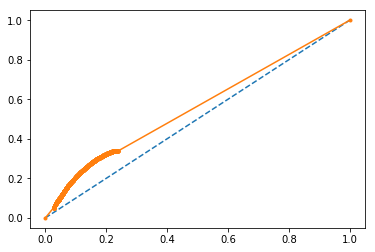

In [37]:
fpr0, tpr0, thresholds0 = metrics.roc_curve(y_test, y_probs)

# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr0, tpr0, marker='.')
# show the plot
pyplot.show()

<a id='feature_importance'></a>
# Feature Importance
<a href=#top>Top</a>

In [75]:
importances = clf0.feature_importances_

In [90]:
len(importances)

35

NameError: name 'plt' is not defined

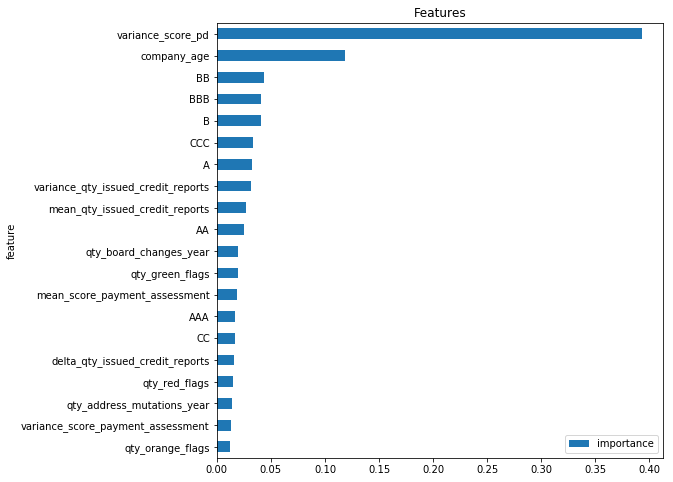

In [115]:
feat_imp = pd.DataFrame({'importance':clf0.feature_importances_})    
feat_imp['feature'] = x_train[features_in_model].columns

feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[:20]
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title='Features', figsize=(8,8))
plt.xlabel('Feature Importance Score')
plt.show()

NameError: name 'plt' is not defined

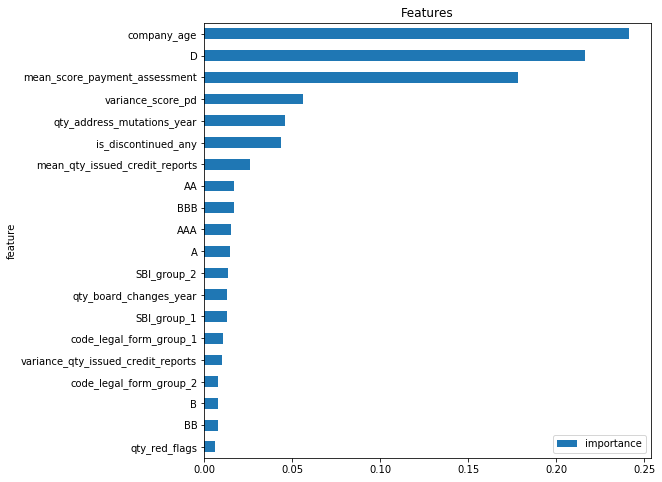

In [118]:
feat_imp = pd.DataFrame({'importance':clfDT.feature_importances_})    
feat_imp['feature'] = x_train[features_in_model].columns

feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[:20]
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title='Features', figsize=(8,8))
plt.xlabel('Feature Importance Score')
plt.show()

In [77]:
len(importances)

35

In [74]:
importances = clf0.feature_importances_
std = np.std([clf0.feature_importances_ for tree in clf0.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

AttributeError: 'DecisionTreeClassifier' object has no attribute 'estimators_'

<a id='balancedata'></a>
## Balance Data:

<a href=#top>Top</a>

In [38]:
train_all = x_train

In [39]:
train_all.columns

Index(['has_name_change', 'delta_qty_issued_credit_reports',
       'delta_score_payment_assessment', 'code_legal_form_has_changed',
       'SBI_has_changed', 'company_age', 'qty_green_flags', 'qty_orange_flags',
       'qty_red_flags', 'A', 'AA', 'AAA', 'B', 'BB', 'BBB', 'C', 'CC', 'CCC',
       'D', 'NR', 'code_legal_form_group_1', 'code_legal_form_group_2',
       'SBI_group_1', 'SBI_group_2', 'is_discontinued_any',
       'has_financial_calamity', 'mean_qty_issued_credit_reports',
       'mean_score_payment_assessment', 'qty_address_mutations_year',
       'qty_started_names_year', 'qty_stopped_names_year',
       'qty_board_changes_year', 'variance_qty_issued_credit_reports',
       'variance_score_payment_assessment', 'variance_score_pd'],
      dtype='object')

In [40]:
train_all['has_relocated_next_year'] = y_train

In [41]:
train_all.shape

(4537409, 36)

In [42]:
train_all.has_relocated_next_year.value_counts() / train_all.shape[0]

0    0.95873
1    0.04127
Name: has_relocated_next_year, dtype: float64

In [43]:
# Choose desired class breakdown
fraction_majority = 0.50

In [44]:
num_minority = train_all[train_all['has_relocated_next_year']==True].shape[0]

num_majority = fraction_majority * num_minority / (1 - fraction_majority)

num_minority, int(num_majority), num_majority, num_majority/(num_majority + num_minority)

(187261, 187261, 187261.0, 0.5)

In [47]:
num_minority = data_df[data_df['has_relocated_next_year']==True].shape[0]

num_majority = fraction_majority * num_minority / (1 - fraction_majority)

num_minority, int(num_majority), num_majority, num_majority/(num_majority + num_minority)

(91577, 91577, 91577.0, 0.5)

In [45]:
# Separate majority and minority classes
df_majority = train_all[train_all.has_relocated_next_year==False]
df_minority = train_all[train_all.has_relocated_next_year==True]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=int(num_majority),     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.has_relocated_next_year.value_counts()

1    187261
0    187261
Name: has_relocated_next_year, dtype: int64

In [115]:
# Separate majority and minority classes
df_majority = data_df[data_df.has_relocated_next_year==False]
df_minority = data_df[data_df.has_relocated_next_year==True]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=int(num_majority),     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.has_relocated_next_year.value_counts()

True     91577
False    91577
Name: has_relocated_next_year, dtype: int64

In [46]:
df_downsampled.has_relocated_next_year.value_counts()/df_downsampled.shape[0]

1    0.5
0    0.5
Name: has_relocated_next_year, dtype: float64

In [47]:
df_downsampled.shape

(374522, 36)

## Remove NaNs from Balanced Dataset:

In [48]:
data_to_model = df_downsampled[features_in_model + ['has_relocated_next_year']]

In [50]:
data_to_model.shape

(374522, 36)

## Check for NAs

Drop rows with NA:

For other options: https://machinelearningmastery.com/handle-missing-data-python/

In [52]:
data_to_model.isnull().values.any()

False

In [68]:
print(data_to_model.isnull().sum())

code_sbi_2                                0
qty_address_mutations_total               0
has_name_change                           0
qty_green_flags                           0
qty_orange_flags                          0
qty_red_flags                             0
A                                         0
AA                                        0
AAA                                       0
B                                         0
BB                                        0
BBB                                       0
C                                         0
CC                                        0
CCC                                       0
D                                         0
NR                                        0
company_age                               0
delta_qty_employees                       0
delta_qty_issued_credit_reports           0
delta_score_payment_assessment            0
code_legal_form_has_changed               0
is_discontinued_any             

Drop rows with NA:

In [69]:
data_to_model.dropna(inplace=True)

# summarize the number of rows and columns in the dataset
print(data_to_model.shape)

(145304, 40)


In [180]:
data_to_model.isnull().values.any()

False

<a id='dt_rebalance'></a>

# Decision Tree on Re-balanced data

<a href=#top>Top</a>

In [53]:
x_re_train, x_re_test, y_re_train, y_re_test = train_test_split(data_to_model[features_in_model], 
                                                                data_to_model.has_relocated_next_year, 
                                                    test_size=0.25, random_state=0)

y_re_train=y_re_train.astype('int')
y_re_test=y_re_test.astype('int')

In [54]:
x_re_train.shape

(280891, 35)

In [55]:
clf = tree.DecisionTreeClassifier()

clf.fit(x_re_train, y_re_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [56]:
# Default DT accuracy:
measure_performance(x_re_train,y_re_train,clf, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.922 



## Write out model:

In [57]:
filename = 'models/DT_defaults_balanced.sav'
pickle.dump(clf, open(filename, 'wb'))

## Tuning:

In [96]:
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [206]:
# Grid searched DT accuracy:
measure_performance(x_re_train,y_re_train, clf, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.633 



In [98]:
parameters = {'max_depth':range(5,20), 'min_samples_split':range(10, 20), 'min_samples_leaf':[2,3,5,10]}
clfB = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
clfB.fit(X=x_re_train, y=y_re_train)
clfDT = clfB.best_estimator_
print (clfB.best_score_, clfB.best_params_)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.6311878985086742 {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 13}


In [99]:
filename = 'models/DT_md5_20_mss10_20_msl2_10_balanced.sav'
pickle.dump(clfDT, open(filename, 'wb'))

In [205]:
parameters = {'max_depth':range(5,20), 'min_samples_split':range(10, 20), 'min_sample_leaf':[2,3,5,10]}
clfB = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
clfB.fit(X=x_re_train, y=y_re_train)
clfDT = clfB.best_estimator_
print (clfB.best_score_, clfB.best_params_)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.6209198345893071 {'max_depth': 10, 'min_samples_split': 15}


In [100]:
# Grid searched DT accuracy:
measure_performance(x_re_train,y_re_train, clfDT, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.650 



## Accuracy on Test Set:

<a href=#top>Top</a>

In [58]:
y_re_pred=clf.predict(x_re_test)

In [101]:
y_re_pred=clfDT.predict(x_re_test)

In [59]:
cnf_matrix = metrics.confusion_matrix(y_re_test, y_re_pred)
cnf_matrix

array([[27593, 19569],
       [18434, 28035]])

In [102]:
cnf_matrix = metrics.confusion_matrix(y_re_test, y_re_pred)
cnf_matrix

array([[26944, 20218],
       [13939, 32530]])

In [103]:
score=metrics.accuracy_score(y_re_test, y_re_pred)

# Get probabilities
y_re_probs = clfDT.predict_proba(x_re_test)

# keep probabilities for the positive outcome only
y_re_probs = y_re_probs[:, 1]

auc = metrics.roc_auc_score(y_re_test, y_re_probs)

kappa = metrics.cohen_kappa_score(y_re_test, y_re_pred)
cr=metrics.classification_report(y_re_test, y_re_pred)

In [104]:
score, auc, kappa

(0.6351956082921255, 0.6915853635199946, 0.2710748835073492)

In [60]:
score=metrics.accuracy_score(y_re_test, y_re_pred)

# Get probabilities
y_re_probs = clf.predict_proba(x_re_test)

# keep probabilities for the positive outcome only
y_re_probs = y_re_probs[:, 1]

auc = metrics.roc_auc_score(y_re_test, y_re_probs)

kappa = metrics.cohen_kappa_score(y_re_test, y_re_pred)
cr=metrics.classification_report(y_re_test, y_re_pred)

In [61]:
score, auc, kappa

(0.594119468979291, 0.5954366468618202, 0.1883401191256333)

In [62]:
print(cr)

              precision    recall  f1-score   support

           0       0.60      0.59      0.59     47162
           1       0.59      0.60      0.60     46469

   micro avg       0.59      0.59      0.59     93631
   macro avg       0.59      0.59      0.59     93631
weighted avg       0.59      0.59      0.59     93631



<a id='plot'></a>
# Plot

<a href=#top>Top</a>


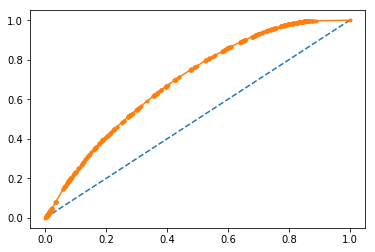

In [105]:
fpr, tpr, thresholds = metrics.roc_curve(y_re_test, y_re_probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

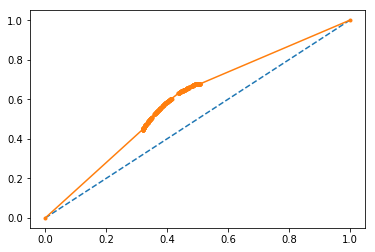

In [63]:
fpr, tpr, thresholds = metrics.roc_curve(y_re_test, y_re_probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

## Verify on Un-balanced test set:

<a href=#top>Top</a>

In [64]:
x_test.shape

(1134353, 35)

In [106]:
y_re_pred_unbalance=clfDT.predict(x_test)

In [107]:
y_re_pred_unbalance.shape

(1134353,)

In [113]:
sum(y_test) / len(y_test), sum(y_test==0) / len(y_test) 

(0.04143066576277402, 0.958569334237226)

In [114]:
sum(y_re_pred_unbalance==1) / len(y_re_pred_unbalance), sum(y_re_pred_unbalance!=1) / len(y_re_pred_unbalance)

(0.4392741941882289, 0.5607258058117711)

In [108]:
cnf_matrix = metrics.confusion_matrix(y_test, y_re_pred_unbalance)
cnf_matrix

array([[621978, 465378],
       [ 14083,  32914]])

In [109]:
score=metrics.accuracy_score(y_test, y_re_pred_unbalance)

# Get probabilities
y_re_probs = clfDT.predict_proba(x_test)

# keep probabilities for the positive outcome only
y_re_probs = y_re_probs[:, 1]

auc = metrics.roc_auc_score(y_test, y_re_probs)

kappa = metrics.cohen_kappa_score(y_test, y_re_pred_unbalance)
cr=metrics.classification_report(y_test, y_re_pred_unbalance)

In [110]:
score, auc, kappa

(0.5773264583423325, 0.6911459728952031, 0.04868823043665782)

In [71]:
score, auc, kappa

(0.5852649043110919, 0.5962064193480675, 0.03524081021117986)

In [111]:
print(cr)

              precision    recall  f1-score   support

           0       0.98      0.57      0.72   1087356
           1       0.07      0.70      0.12     46997

   micro avg       0.58      0.58      0.58   1134353
   macro avg       0.52      0.64      0.42   1134353
weighted avg       0.94      0.58      0.70   1134353



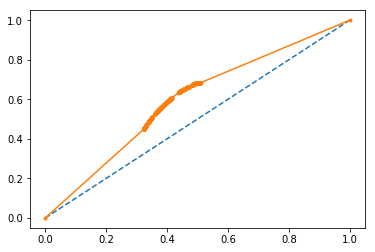

In [73]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_re_probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

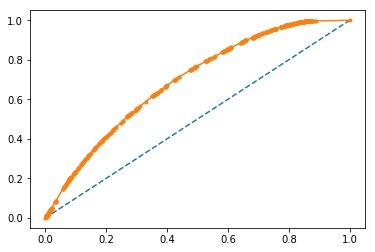

In [112]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_re_probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

<a id='bottom'></a>

<a href=#top>Top</a>
# End